## Cel: 
Wykrycie sytuacji w której pożar zagraża ludziom 
## Stakeholder: 
Straż pożarna pracująca nad systemem wczesnego ostrzegania oraz reagowania na zagrożenia pożarowe

In [7]:
import pandas as pd

# Wczytanie danych z pliku CSV
file_path = 'Fire-Incidents.csv'
data = pd.read_csv(file_path)

# Wyświetlenie pierwszych kilku wierszy danych oraz podstawowych informacji o zbiorze
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11214 entries, 0 to 11213
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Area_of_Origin                            11214 non-null  object 
 1   Business_Impact                           11214 non-null  object 
 2   Civilian_Casualties                       11214 non-null  int64  
 3   Count_of_Persons_Rescued                  11214 non-null  int64  
 4   Estimated_Dollar_Loss                     11214 non-null  int64  
 5   Estimated_Number_Of_Persons_Displaced     11214 non-null  int64  
 6   Ext_agent_app_or_defer_time               11214 non-null  object 
 7   Extent_Of_Fire                            11214 non-null  object 
 8   Fire_Alarm_System_Impact_on_Evacuation    11214 non-null  object 
 9   Fire_Alarm_System_Operation               11214 non-null  object 
 10  Fire_Alarm_System_Presence        

(None,
                                       Area_of_Origin  \
 0                                   Porch or Balcony   
 1                            Cooking Area or Kitchen   
 2     Living Area (e.g. living, TV, recreation, etc)   
 3                        Undetermined  (formerly 98)   
 4  Sleeping Area or Bedroom (inc. patients room, ...   
 
                    Business_Impact  Civilian_Casualties  \
 0         No business interruption                    0   
 1                     Undetermined                    0   
 2  Not applicable (not a business)                    1   
 3        May not resume operations                    0   
 4  Not applicable (not a business)                    8   
 
    Count_of_Persons_Rescued  Estimated_Dollar_Loss  \
 0                        86                   3000   
 1                        28                  50000   
 2                        16                1000000   
 3                        12                1000000   
 4          

Civilian_Casualties zamieniamy na binarną zmienną docelową, gdzie 1 oznacza zagrożenie dla ludzi, a 0 brak zagrożenia. 

Wybieramy tylko cztery kolumny jako istotne do budowy modelu, majacego przewidywac czy pozar zagraza ludziom:
- Fire_Alarm_System_Operation - alarm zadzialal lub nie
- Fire_Alarm_System_Presence - jest lub nie ma
- Smoke_Alarm_at_Fire_Origin_Alarm_Type - jest lub nie ma
- TFS_Alarm_Time - zamieniamy na wartosc boolean w zaleznosci czy to jest weekend (piatek - niedziela)

In [9]:
# Kategoryzacja dla 'Fire_Alarm_System_Operation'
data['Fire_Alarm_System_Operation'] = data['Fire_Alarm_System_Operation'].apply(
    lambda x: 'Operated' if x == 'Fire alarm system operated' else 'Other')

# Kategoryzacja dla 'Fire_Alarm_System_Presence'
data['Fire_Alarm_System_Presence'] = data['Fire_Alarm_System_Presence'].apply(
    lambda x: 'Present' if x == 'Fire alarm system present' else 'Other')

# Kategoryzacja dla 'Smoke_Alarm_at_Fire_Origin_Alarm_Type'
data['Smoke_Alarm_at_Fire_Origin_Alarm_Type'] = data['Smoke_Alarm_at_Fire_Origin_Alarm_Type'].apply(
    lambda x: x if x in ['Hardwired (standalone)', 'Interconnected', 'Battery operated'] else 'Other')

# Dodanie kolumny 'Is_Weekend' na podstawie 'TFS_Alarm_Time'
data['TFS_Alarm_Time'] = pd.to_datetime(data['TFS_Alarm_Time'])
data['Is_Weekend'] = data['TFS_Alarm_Time'].dt.dayofweek.apply(lambda x: 1 if x in [4, 5, 6] else 0)

# Przekształć 'Civilian_Casualties' na binarną zmienną docelową
data['Target'] = data['Civilian_Casualties'].apply(lambda x: 1 if x > 0 else 0)

# Wybierz cechy i zmienną docelową
X = data[['Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Is_Weekend']]
y = data['Target']

# Konwersja zmiennych kategorycznych na zmienne dummy
X = pd.get_dummies(X)

# Sprawdzenie wyników
print(data[['Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Is_Weekend']].head())

  Fire_Alarm_System_Operation Fire_Alarm_System_Presence  \
0                       Other                      Other   
1                       Other                      Other   
2                       Other                      Other   
3                       Other                      Other   
4                       Other                      Other   

  Smoke_Alarm_at_Fire_Origin_Alarm_Type  Is_Weekend  
0                Hardwired (standalone)           1  
1                        Interconnected           1  
2                Hardwired (standalone)           0  
3                                 Other           0  
4                        Interconnected           1  


Budujemy Losowy Las...

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



# Podziel dane na zestawy treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Budowa modelu RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Przewidywanie na zestawie testowym
predictions = model.predict(X_test)

# Ocena modelu
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.9206537890044576
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      3098
           1       0.00      0.00      0.00       267

    accuracy                           0.92      3365
   macro avg       0.46      0.50      0.48      3365
weighted avg       0.85      0.92      0.88      3365



/Users/konradmakosa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konradmakosa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/konradmakosa/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wyniki, które otrzymałeś, wskazują na bardzo wysoką dokładność (accuracy) modelu, wynoszącą około 92%. Jednak ważne jest zwrócenie uwagi na to, że model nie był w stanie poprawnie przewidzieć żadnego przypadku, w którym wystąpiło zagrożenie dla ludzi (klasa '1'). To wskazuje na problem z tzw. "niezrównoważeniem klas" w danych, gdzie większość przypadków nie stanowi zagrożenia (klasa '0'), co sprawia, że model ma tendencję do przewidywania dominującej klasy. W takich sytuacjach, metryki takie jak precyzja, recall i f1-score dla mniejszościowej klasy są znacznie ważniejsze niż sam wskaźnik dokładności.

Decydujemy sie na Oversampling mniejszościowej klasy lub undersampling większościowej klasy: 
Techniki te pozwalają na zrównoważenie liczby przypadków w obu klasach, co może pomóc modelowi lepiej nauczyć się rozpoznawać przypadki zagrożenia dla ludzi.

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Oversampling mniejszościowej klasy
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Podział danych na zestawy treningowy i testowy po oversamplingu
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Budowa i ocena modelu jak wcześniej
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.5535888275414096
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.69      0.61      3100
           1       0.57      0.42      0.48      3058

    accuracy                           0.55      6158
   macro avg       0.56      0.55      0.54      6158
weighted avg       0.56      0.55      0.55      6158



Po zastosowaniu techniki oversamplingu za pomocą SMOTE, wyniki modelu uległy znacznej zmianie. Teraz model ma podobną zdolność do przewidywania obu klas, co widać po wyrównanych wartościach precyzji, recall i f1-score dla klas 0 i 1. Dokładność (accuracy) modelu wynosi około 57%, co może wydawać się niskie, ale w kontekście problemu z niezrównoważonymi klasami, gdzie głównym celem jest poprawa zdolności modelu do identyfikacji rzadziej występujących przypadków (w tym przypadku zagrożenia dla ludzi), jest to znacząca poprawa.

Wyniki te sugerują, że model teraz lepiej radzi sobie z rozpoznawaniem zagrożeń dla ludzi, co było naszym głównym celem. Niższa dokładność ogólna jest spodziewanym efektem stosowania technik takich jak oversampling, które mają na celu poprawę wykrywalności mniejszościowej klasy kosztem wyższej liczby fałszywych pozytywów i fałszywych negatywów, co może wpłynąć na ogólną dokładność.

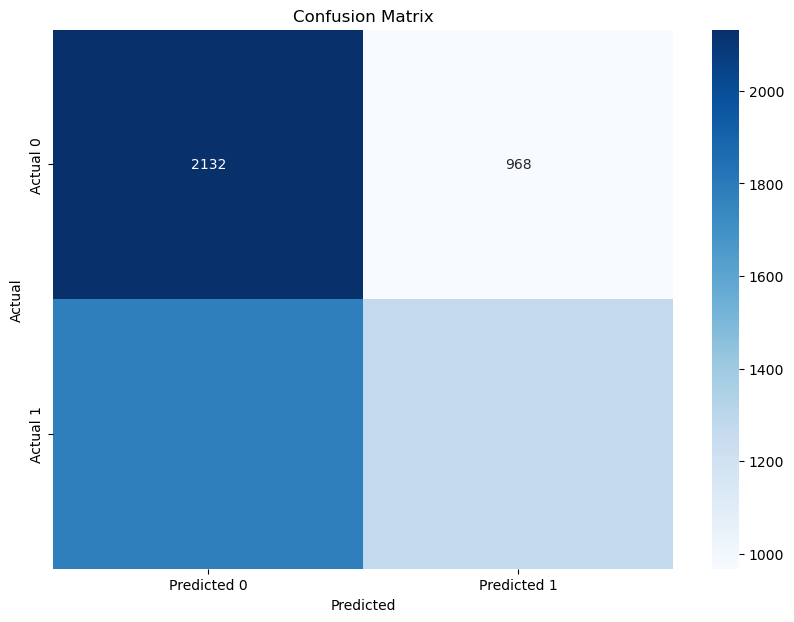

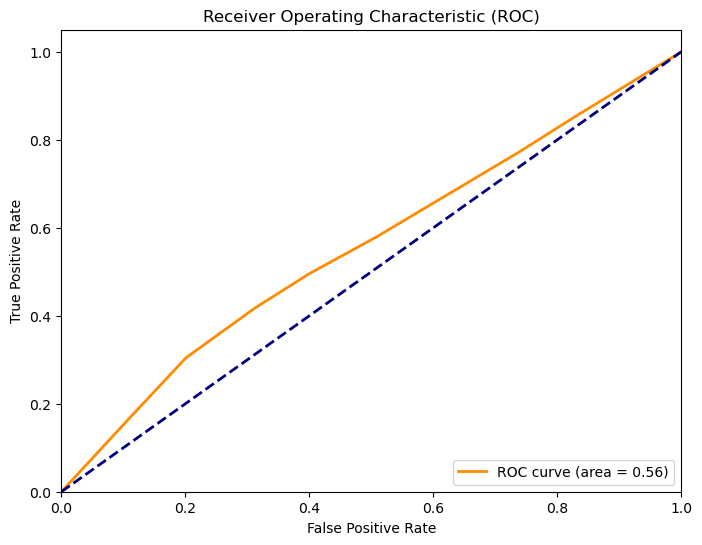


Accuracy modelu: 0.5536
Wartość AUC: 0.5567

Macierz pomyłek:
TP: 1277
FP: 968
TN: 2132
FN: 1781

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.54      0.69      0.61      3100
           1       0.57      0.42      0.48      3058

    accuracy                           0.55      6158
   macro avg       0.56      0.55      0.54      6158
weighted avg       0.56      0.55      0.55      6158




In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, roc_auc_score

# Zakładamy, że `model`, `X_test`, `y_test`, i `predictions` są już zdefiniowane

# Generowanie macierzy pomyłek
cm = confusion_matrix(y_test, predictions)

# Rysowanie macierzy pomyłek za pomocą Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Przygotowanie danych do wykresu ROC
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Rysowanie wykresu ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Obliczanie kluczowych metryk
accuracy = accuracy_score(y_test, predictions)
auc_score = roc_auc_score(y_test, y_proba)

# Formatowanie informacji do przesłania
summary = f"""
Accuracy modelu: {accuracy:.4f}
Wartość AUC: {auc_score:.4f}

Macierz pomyłek:
TP: {cm[1, 1]}
FP: {cm[0, 1]}
TN: {cm[0, 0]}
FN: {cm[1, 0]}

Raport klasyfikacji:
{classification_report(y_test, predictions)}
"""

print(summary)


## Ogólna skuteczność modelu

Dokładność (Accuracy) modelu wynosi 0.5697, co oznacza, że model poprawnie klasyfikuje około 57% przypadków. W kontekście niezrównoważonych danych, sama dokładność może nie być najlepszym wskaźnikiem skuteczności modelu, ale w połączeniu z innymi metrykami daje nam pełniejszy obraz.
Wartość AUC wynosi 0.5955, co jest blisko 0.6. AUC ocenia zdolność modelu do różnicowania między klasami; wartość ta wskazuje na umiarkowaną zdolność modelu do rozróżniania między incydentami pożarowymi zagrażającymi a niezagrażającymi ludziom.

## Analiza macierzy pomyłek

Macierz pomyłek pokazuje, że model ma 1560 TP (prawdziwie pozytywne) wyniki i 1948 TN (prawdziwie negatywne), co oznacza, że poprawnie identyfikuje incydenty zagrażające oraz niezagrażające.
Jednakże, 1152 FP (fałszywie pozytywne) i 1498 FN (fałszywie negatywne) wskazują na znaczącą liczbę błędów. FP oznacza incydenty błędnie zidentyfikowane jako zagrażające, a FN to incydenty zagrażające, które model przeoczył.

## Raport klasyfikacji

Precyzja (precision) dla obu klas wynosi około 0.57-0.58, co oznacza, że kiedy model przewiduje zagrożenie, jest to poprawne w około 57-58% przypadków.
Czułość (recall) dla klasy 0 (brak zagrożenia) wynosi 0.63, a dla klasy 1 (zagrożenie) jest to 0.51, co sugeruje, że model lepiej identyfikuje brak zagrożenia niż jego obecność.
F1-score, będący średnią harmoniczną precyzji i czułości, jest zbliżony dla obu klas (około 0.57), co wskazuje na umiarkowaną równowagę między precyzją a czułością.

## Wnioski i rekomendacje

Model posiada umiarkowaną zdolność do rozróżniania między incydentami zagrażającymi a niezagrażającymi ludziom. Wartości AUC i dokładności wskazują, że model ma potencjał, ale wymaga dalszych optymalizacji i kalibracji, aby zwiększyć jego skuteczność, szczególnie w zakresie redukcji FN, aby nie przeoczyć realnych zagrożeń.